<h1>1. Introduction to Sentiment Analysis</h1>

Sentiment analysis, also known as opinion mining, is a subfield of natural language processing (NLP) that involves analyzing the sentiment or emotion expressed in a piece of text. Sentiment analysis is widely used in applications such as social media monitoring, customer feedback analysis, and market research.

Sentiment analysis can be performed at different levels, ranging from individual words and phrases to entire documents or conversations. The simplest approach to sentiment analysis is to use a lexicon-based method, where a set of words or phrases with known sentiment polarities (positive or negative) is used to determine the overall sentiment of a piece of text. However, lexicon-based methods can be limited in their accuracy and applicability, as they often fail to capture the context and nuances of language.

A more sophisticated approach to sentiment analysis involves machine learning techniques, such as supervised or unsupervised learning, which can learn from labeled data and generalize to new data. In supervised learning, a model is trained on a labeled dataset of text and corresponding sentiment polarities, and can then be used to predict the sentiment of new text. In unsupervised learning, the model learns patterns and clusters in the data without the use of labeled data.

In this notebook, we will focus on building a sentiment analysis model using Pytorch and the supervised learning approach. Specifically, we will build a model to predict the sentiment polarity of beer reviews, using a dataset of beer reviews with corresponding positive or negative labels. We will use an LSTM-based neural network to learn from the text data, and evaluate the performance of the model using various metrics.

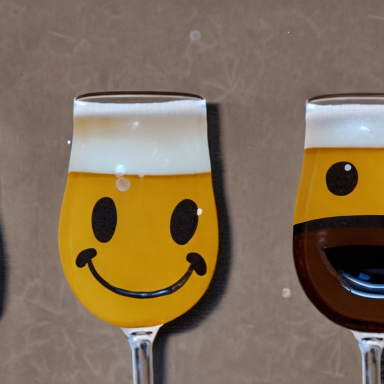

<h1>2. Data collection and preparation</h1>

Let's import the neccessary libraries. Probably you'll need to install scikit-learn and NLTK in your environment.

In [1]:
%pip install seaborn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Configure a GPU if it exists. If not, use the CPU
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
import nltk as nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PedroAnquela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now it's time to load the tagged beer reviews file, and prepare the datasets.

In [4]:
base_csv = 'data/beer/beer_reviews.csv'
df = pd.read_csv(base_csv)
df.head(10)


,sentiment,text
0,positive,a : clear and very pale yellow color . poured ...
1,negative,ruby redbird served in new belgium globe glass...
2,negative,very light colour with some sizzling head than...
3,negative,bottle `` best before '' date : 10/2004 appear...
4,positive,had a can of this yesterday after finishing bu...
5,positive,"i purchased this at a hyvee in omaha , nebrask..."
6,negative,smells like a bag of mixed hop pellets . this ...
7,positive,"a : golden with an amber hue , serves with a d..."
8,positive,"i must say , if this is the type of pale lager..."
9,positive,~ 12 oz bottle this beer pours dark brown with...


You can observe that the dataset contains a column with either 'positive' or 'negative' sentiment, and a second column with the review text, which seems to have already been preprocessed somehow (text is lowercase, and special characters are surrounded by a space).

To prepare train, dev and test datasets, let's make use of the *train_test_split()* function that Scikit-Learn provides.
We instruct it to 'stratify' the sentiment label, which will sample the dataset ensuring that each class in the dataset is represented in the same proportion in all datasets.

You can check the shapes of the resulting datasets to check the ratios.

In [34]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X, y = df['text'].values, df['sentiment'].values


x_train_text, x_2_text, y_train, y_2 = train_test_split(X, y, test_size=1 - train_ratio, stratify=y)
x_val_text, x_test_text, y_val, y_test = train_test_split(x_2_text, y_2, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_2) 

#x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, stratify=y)

print(f'shape of train data is {x_train_text.shape}')
print(f'shape of train data is {x_val_text.shape}')
print(f'shape of test data is {x_test_text.shape}')


shape of train data is (22500,)
shape of train data is (4500,)
shape of test data is (3000,)


This sentiment analysis is going to be a binary classification task.

Let's check if the dataset is balanced. You can plot with Seaborn library the amount of positive and negative reviews the train dataset contains.

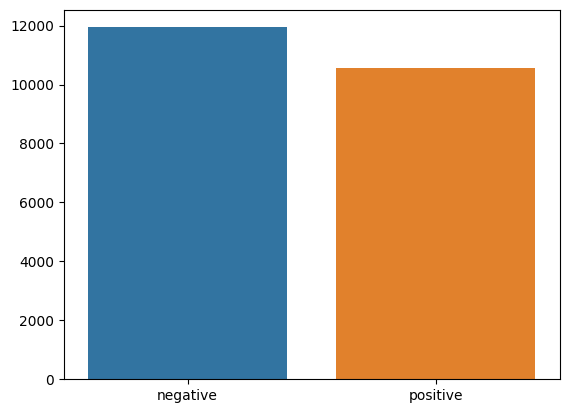

In [35]:
dd = pd.Series(y_train).value_counts()

sns.barplot(x=np.array(['negative','positive']), y=dd.values)
plt.show()


Fair enough!

If we had an imbalanced dataset (a class having significantly more samples than the other), it could led to biased models that perform poorly on the minority class. Some techniques can be used to address that issue, but we won't consider such scenario since our dataset seems to be quite well balanced.

Let's define a function which will later preprocess the words of each review. It will:

- remove non-word characters (everything except numbers and letters)
- remove whitespaces

<strong>Exercise 1</strong>. Just to practice with basic regular expressions, very used with text processing, also add to the function an additional step which removes digits:

In [36]:
def preprocess_word(s):
    # Remove all non-word characters
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space

    ### Your code starts here ###

    # s = 

    ### Your code ends here ###
    
    return s


Now one of the most important functions must be defined, the **TOKENIZER**.

A dictionary will be created with one-hot-encoded tokens, and the text of the beer reviews will be converted to an array of encoded tokens, which we will be able to feed our neural network with.

This function will take as input the initial train and test datasets, and:

- For each text string of the Training dataset:

   it will take each word (or token) converted to lowercase, perform our *preprocess_word* procedure, check if it is a _stop word_ (considered to be insignificant, such as "the, is, at, which, on, .."), and if it must be kept it will be stored in a list named *word_list*.

- A Python counter dictionary will be created, which will hold all the stored words with their frequency. This will let us order the words to get the *N* most common words. This will be our **DICTIONARY**.

- Then, for each text string of the Training dataset as well as of the Testing dataset:

   it will take each word converted to lowercase, and if it exists in the dictionary, the encoded value of the word will be appended to the lists named 'final_list_'.

- The 'negative' and 'positive' sentiment labels are converted to 0 and 1 numbers.

<strong>Exercise 2</strong>. Replicate the tokenization part of the function for the test dataset:

In [37]:
N = 5_000

def tokenize(x_train, y_train, x_val, y_val, x_test, y_test):

    # Create dictionary
    word_list = []

    stop_words = set(stopwords.words('english'))
    for text in x_train:
        for word in text.lower().split():
            word = preprocess_word(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:N]
    # Creating a dictionary
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}


    # Tokenize
    final_list_train, final_list_val, final_list_test = [],[],[]

    # Training dataset
    for text in x_train:
        final_list_train.append([onehot_dict[preprocess_word(word)] for word in text.lower().split()
        if preprocess_word(word) in onehot_dict.keys()])

    # Validation dataset
    for text in x_val:
        final_list_val.append([onehot_dict[preprocess_word(word)] for word in text.lower().split()
        if preprocess_word(word) in onehot_dict.keys()])

    # Testing dataset
    ### Your code starts here ###

    for text in x_test:
        final_list_test.append([onehot_dict[preprocess_word(word)] for word in text.lower().split()
        if preprocess_word(word) in onehot_dict.keys()])
    
    ### Your code ends here ###

    # Encode sentiment labels as a number
    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_val = [1 if label =='positive' else 0 for label in y_val]
    encoded_test = [1 if label =='positive' else 0 for label in y_test]

    return final_list_train, encoded_train, final_list_val, encoded_val, final_list_test, encoded_test, onehot_dict


x_train, y_train, x_val, y_val, x_test, y_test, vocab = tokenize(x_train_text, y_train, x_val_text, y_val, x_test_text, y_test)
print(f'Length of vocabulary is {len(vocab)}')


Length of vocabulary is 5000


<strong>Exercise 3</strong>. Find the top-3 most frequent words:

In [38]:
### Your code starts here ###



### Your code ends here ###

['beer', 'head', 'taste']

Let's now analyse the lengths of the training encoded text of the reviews:

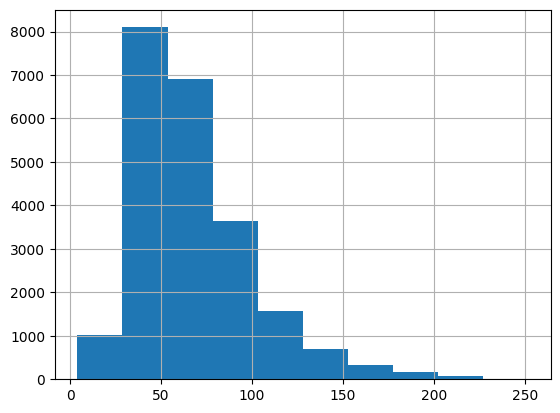

count    22500.000000
mean        67.341556
std         32.897775
min          4.000000
25%         44.000000
50%         60.000000
75%         83.000000
max        252.000000
dtype: float64

In [39]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()


We can see that the mean encoded beer review length is around 67 tokens, while the minimum length is just 4.

There are a few reviews that are longer than 150 tokens. One could manually investigate them to check whether we need to include or exclude them from our analysis, but let's just get rid of reviews longer than 128 tokens for the moment.

In [40]:
MAX_LENGTH = 128

We need all encoded reviews to be of the same length, so we are going to truncate reviews longer than MAX_LENTH and apply **PADDING** to reviews shorter than it (add tokens of value 0).

Let's define a function which does that, with the padding tokens added at the beggining of the array.

In [41]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train, MAX_LENGTH)
x_val_pad = padding_(x_val, MAX_LENGTH)


Now we are ready to convert the encoded vectors to Tensors, and prepare the batched datasets with Pytorch's DataLoader class.

<strong>Exercise 4</strong>. Create the train_loader and valid_loader Dataloaders with the correct data, batch_size, and don't forget to enable shuffling!

In [42]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(x_train_pad)), torch.from_numpy(np.array(y_train)))
valid_data = TensorDataset(torch.from_numpy(np.array(x_val_pad)), torch.from_numpy(np.array(y_val)))

# dataloaders
batch_size = 50

# Create the DataLoaders
# make sure to SHUFFLE your data!
### Your code starts here ###

# train_loader = 
# valid_loader = 

### Your code ends here ###

Let's review what a batch looks like:

In [43]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample batch input size: ', sample_x.size()) # batch_size, seq_length
print('\nSample batch input encoded texts: \n', sample_x)
print('\nSample batch input encoded labels: \n', sample_y)

Sample batch input size:  torch.Size([50, 128])

Sample batch input encoded texts: 
 tensor([[   0,    0,    0,  ..., 1268,  388,    8],
        [   0,    0,    0,  ...,  155,  343, 4119],
        [   0,    0,    0,  ...,   27, 2161,  761],
        ...,
        [   0,    0,    0,  ...,  238,   63,  289],
        [   0,    0,    0,  ...,   48,  134, 1674],
        [   0,    0,    0,  ...,  873,   61,   50]], dtype=torch.int32)

Sample batch input encoded labels: 
 tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1], dtype=torch.int32)


<h1>3. Building the model</h1>

We are going to define the architecture of our network, using an LSTM, which thanks to PyTorch is really simple to implement.

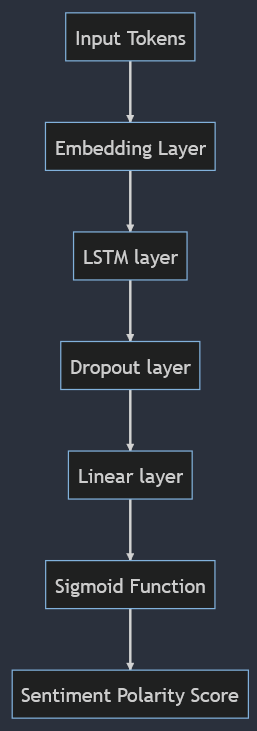



First, we need to add an **embedding** layer, whose purpose is to create a low-dimensional representation of words that captures their semantic meaning. This is achieved by assigning each word in the vocabulary a vector of numbers, called an embedding, such that semantically similar words are represented by vectors that are close together in the embedding space.

Next comes the LSTM. The number of layers in an LSTM architecture refers to the number of stacked LSTM cells in the network. Each layer processes the input sequence and produces a corresponding output sequence, which can be passed as input to the next layer in the network. By increasing the number of layers, the network can learn more complex representations of the input sequence, but at the cost of increased computational complexity and the potential for overfitting to the training data.

In general, the number of layers in an LSTM architecture is a hyperparameter that can be tuned based on the specific task and the size of the training dataset. More layers may be beneficial for larger datasets or more complex tasks, while fewer layers may be sufficient for smaller datasets or simpler tasks.

Also a dropout layer is applyed as a regularization technique that helps prevent overfitting.

Finally a fully connected layer will be used to map the learned features to the final output. The sigmoid activation function will map the FC layer output to a value between 0 and 1, which is useful for modeling probabilities with binary classification problems.

<strong>Exercise 5</strong>. Complete the definition of the SentimentRNN network by adding the Embedding and LSTM layers:

In [44]:
class SentimentRNN(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.vocab_size = vocab_size


        # Add the Embedding layer, passing the vocabulary size and the embedding dimension.
        # Then add the LSTM layer, with the correct input_size, hidden_size, num_layers. Don't forget to specify
        # that the batch dimension is first.

        ### Your code starts here ###

        # Embedding
        # self.embedding = 
        
        # LSTM
        # self.lstm = 
        
        ### Your code ends here ###
        

        # Dropout layer
        # self.dropout = 
    
        # Linear and Sigmoid layer
        # self.fc = 
        # self.sig = 
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        # lstm_out, hidden = 
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        # out = 
        # out = 
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


We are almost ready. Let's define the hyperparameters and instantiate the model.

In [45]:
n_layers = 2 # Embedding layers
vocab_size = len(vocab) + 1  # One extra token for padding
embedding_dim = 64
hidden_dim = 256
output_dim = 1
drop_prob = 0.5

model = SentimentRNN(n_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob)

# Move model to GPU
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(5001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


The criterion to minimize the loss function is going to be the **Binary Cross Entropy**, which is a measure of the difference between the predicted probability values and the true binary labels. Don't you agree?

In [46]:
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


<h1>4. Training the model</h1>

As usual, we now need to create the loop which iterates through the number of defined epochs.

In [47]:
epochs = 5


clip = 5 # for gradient clipping

valid_loss_min = np.Inf

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0

    model.train()
    
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    
    model.eval()
    
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        #torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss change ({:.6f} --> {:.6f}).'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(35*'==')

Epoch 1
train_loss : 0.66839859187603 val_loss : 0.6898251745435927
train_accuracy : 57.61777777777778 val_accuracy : 53.08888888888889
Validation loss change (inf --> 0.689825).
Epoch 2
train_loss : 0.5961870857079824 val_loss : 0.5259833839204576
train_accuracy : 67.2311111111111 val_accuracy : 75.2
Validation loss change (0.689825 --> 0.525983).
Epoch 3
train_loss : 0.48293653746445975 val_loss : 0.4679090879029698
train_accuracy : 77.44444444444444 val_accuracy : 78.24444444444445
Validation loss change (0.525983 --> 0.467909).
Epoch 4
train_loss : 0.42397988501522277 val_loss : 0.4373147252533171
train_accuracy : 81.34666666666666 val_accuracy : 80.02222222222221
Validation loss change (0.467909 --> 0.437315).
Epoch 5
train_loss : 0.38398642367786834 val_loss : 0.4438240206903882
train_accuracy : 83.44444444444444 val_accuracy : 79.95555555555556


<strong>Exercise 6</strong>. Plot the train and validation accuracy and loss:

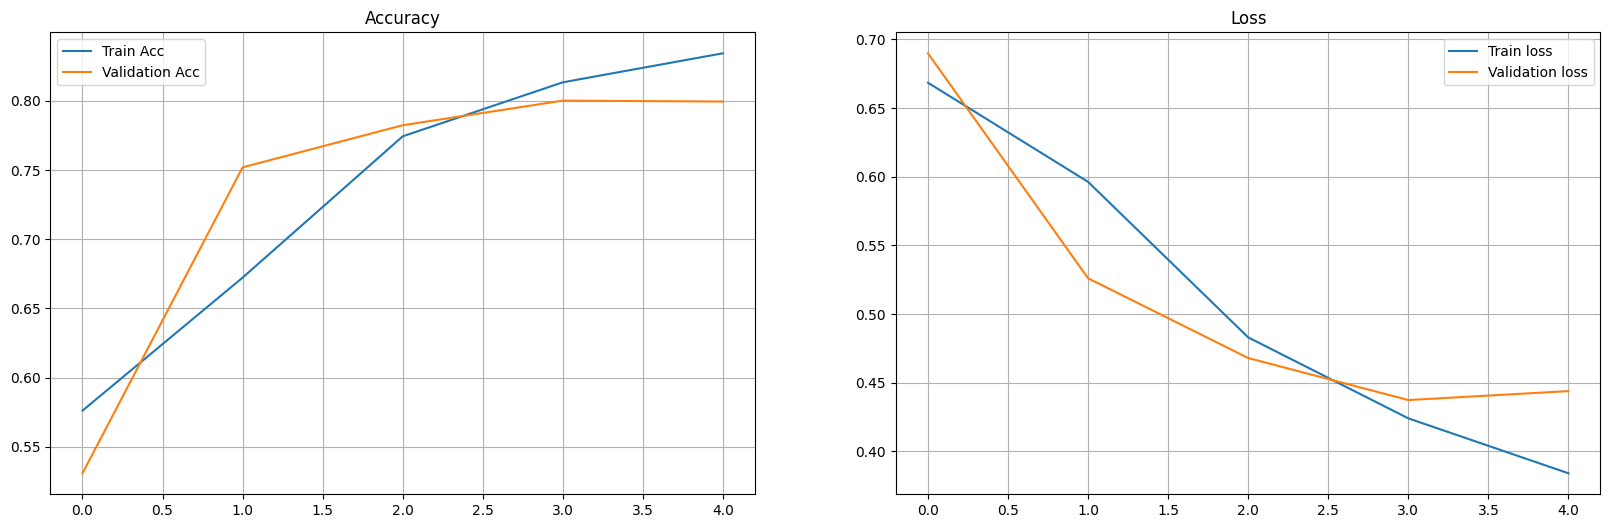

In [49]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)

### Your code starts here ###



### Your code ends here ###

plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)

### Your code starts here ###



### Your code ends here ###

plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

<h1>5. Testing the model</h1>

If you are happy with the training results, it's time to check how well it performs with the test dataset.

Let's define a function which receives the text for which the sentiment will be predicted. As you should already now, the steps it needs to perform are:
- Split the text in tokens (words) and convert them to one-hot-encoded vectors.
- Truncate or pad to the defined MAX_LENGTH
- Get the prediction from the model

Let's now get the binary accuracy metric:

In [50]:
x_test_pad = padding_(x_test, MAX_LENGTH)
test_data = TensorDataset(torch.from_numpy(np.array(x_test_pad)), torch.from_numpy(np.array(y_test)))
test_loader = DataLoader(test_data, batch_size=batch_size)

test_h = model.init_hidden(batch_size)
test_acc = 0.0

for inputs, labels in test_loader:
    test_h = tuple([each.data for each in test_h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, test_h = model(inputs, test_h)
    accuracy = acc(output,labels)
    test_acc += accuracy
test_tot_acc = test_acc/len(test_loader.dataset)

print('Test accuracy: {:.2f}'.format(test_tot_acc))

Test accuracy: 0.79


What do you think? Is it good enough?

Let's explore individual reviews. For this, we are going to create a predict_text function which will return the sentiment prediction for a text string.

<strong>Exercise 7</strong>. Complete the predict_text function, passing the sequence of words to the padding function. Then, move the Tensor to the GPU.

In [51]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_word(word)] for word in text.split() 
                         if preprocess_word(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)

        ### Your code starts here ###

        # pad =  
        # inputs = 

        ### Your code ends here ###

        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

Pick a random sample from the test dataset, and explore the review text and the prediction.

In [52]:
index = np.random.randint(len(x_test_text))

print(x_test_text[index])
print('='*75)
sent = 'negative' if y_test[index]< 1 else 'positive'
print(f'Actual sentiment is: {sent}')
print('='*75)

pro = predict_text(x_test_text[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} (with a probability of {pro})')


ah well the pour was a very light golden color with a very minimal white head . the carbonation goes on forvever , little bubbles very active through the whole brew . not a whole lot going on in the aroma department . a little bit of malt , but most notable was the fresh hay/grass smell , add some grain in there and that sums it up . the taste was fairly refreshing although not real flavorful . first impression is the little bit of malt that comes through followed by a very grainy taste . almost a bit of corn in the finish that leaves a subpar aftertaste . mouthfeel is pretty thin but this beer is n't terrible . sort of refreshing .
Actual sentiment is: positive
Predicted sentiment is negative (with a probability of 0.836686372756958)


Try your own reviews!

<strong>Exercise 8</strong>. Predict the sentiment of your own positive and negative reviews.

In [21]:
### Your code starts here ###

# pos_text= 
# neg_text= 

pro = predict_text(pos_text)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'For the positive review, predicted sentiment is {status} (with a probability of {pro})')

pro = predict_text(neg_text)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'For the negative review, predicted sentiment is {status} (with a probability of {pro})')

### Your code ends here ###

For the positive review, predicted sentiment is negative (with a probability of 0.5011983811855316)
For the negative review, predicted sentiment is negative (with a probability of 0.876426063477993)


Did it work fine?

There is a lot of room for improvement. For instance, you can learn about the following topics and try to implement them:
- Using a bi-directional LSTM layer. With it, information is processed both forwards and backwards through the network, allowing the network to have access to future as well as past context when making predictions.
- Using Packed Padded Sequences, which allow for more efficient processing of variable-length sequences. In this technique, a list of sequences is sorted by length and then packed into a single tensor, with additional padding added to make all sequences the same length. A separate tensor of the original sequence lengths is also created and passed to the model, so that the model can differentiate between real sequence elements and padding.
- Multi-layer LSTM (deep RNN). You can add additional LSTMs on top of the initial standard LSTM and check if the model improves its predictions.
- Try n-grams. For instance, a bigram (or 2-gram) is a sequence of two adjacent words in a text. This way, a token in the dictionary is comprised of two consecutive words instead of just one.

Moreover, in this notebook you have implemented your own tokenizer, and your network needed to learn the weights for the embeddings layer.
But you could have used existing professional tokenizers such as that of [spaCy](https://spacy.io/), and already pretrained embedding models such as **Word2Vec**. With this model, the embeddings are already learned (trained on very large datasets) and can be loaded directly into memory without the need for additional training.

<strong>Exercise 9</strong>. Implement the improvements you like!